# IMAGINE tutorial 2 -- another example.

### (Using a different toy model for the field and its corresponding toy simulator.)

In Tutorial 1, we briefly reviewed the basic features in IMAGINE.

This tutorial will not teach you new features in IMAGINE, but does the same analysis on a different field model. This will give you an idea of how some fields are easier to determine than others using these methods. 

The field in this tutorial is designed to mimick emission intensities which is roughly proportional to (Galactic) magnetic field energy density, e.g. field  strength squared.

$ signal(x) = [sin(x) * \mathcal{G}(mean=a0,std=b0;seed=s)]^2 $, $x \in (0,2\pi)$

You will see that the influence of having variance-like fluctuations in the observable differs dramatically from what we have seen in tutorial 1.

This tutorial has a threshold in data size, i.e. taking $ size<5 $ in this tutorial will fail.

sampling efficiency is highly suppressed

<span style="color:red">**the following calculations are quite expensive**</span>

In [1]:
import numpy as np
import logging as log

from imagine.observables.observable_dict import Simulations, Measurements, Covariances
from imagine.likelihoods.ensemble_likelihood import EnsembleLikelihood
from imagine.fields.test_field.test_field_factory import TestFieldFactory
from imagine.priors.flat_prior import FlatPrior
from imagine.simulators.test.bi_simulator import BiSimulator
from imagine.pipelines.multinest_pipeline import MultinestPipeline
from imagine.tools.covariance_estimator import oas_cov

# visualize posterior
import corner
import matplotlib
from imagine.tools.carrier_mapper import unity_mapper
matplotlib.use('Agg')

%matplotlib inline

## step 1, mock data preparation

For explanation, see tutorial 1.

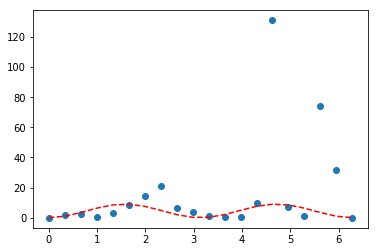

In [2]:
a0 = 3. # true value of a
b0 = 6. # true value of b
e = 0.1 # std of gaussian measurement error
s = 233 # seed fixed for signal field

size = 20
x = np.linspace(0,2.*np.pi,size)

np.random.seed(s)

signal = np.square (np.multiply (np.sin(x), np.random.normal(loc=a0,scale=b0,size=size)))

data = np.vstack([signal + np.random.normal(loc=0.,scale=e,size=size)])

cov = (e**2) * np.eye(size)

mock_data = Measurements()
mock_data.append(('test', 'nan', str(size), 'nan'), data, True)

mock_cov = Covariances() # create empty Covariance object
mock_cov.append(('test', 'nan', str(size), 'nan'), cov, True)

matplotlib.pyplot.scatter(x, mock_data[('test', 'nan', str(size), 'nan')].to_global_data()[0])
matplotlib.pyplot.plot(x,(np.sin(x)*a0)**2,'r--')

## step 2, pipeline preparation
The simulator used for this example is BiSimulator, consisting of the emissivity function defined above.

In [3]:
factory = TestFieldFactory(active_parameters=('a','b'))
factory.parameter_ranges = {'a':(0,10),'b':(0,10)}
factory_list = [factory]

simer = BiSimulator(mock_data) # now we use a different simulator

prior = FlatPrior()

likelihood = EnsembleLikelihood(mock_data, mock_cov)

ensemble_size = 100
pipe = MultinestPipeline(simer, factory_list, likelihood, prior, ensemble_size)
pipe.random_seed = 0 # favor fixed seed? try a positive integer
pipe.sampling_controllers = {'n_iter_before_update': 1,
                             'n_live_points': 400,
                             'verbose': False,
                             'resume': False}

## step 3, roll out with MultiNest

In [ ]:
results = pipe()

samples = results['samples']  # load sample points

for i in range(len(pipe.active_parameters)): # convert variables into parameters
    low, high = pipe.active_ranges[pipe.active_parameters[i]]
    for j in range(samples.shape[0]):
        samples[j,i] = unity_mapper(samples[j,i],low,high)

# corner plot
figure = corner.corner(samples[:, :len(pipe.active_parameters)],
                       range=[0.99]*len(pipe.active_parameters),
                       quantiles=[0.02, 0.5, 0.98],
                       labels=pipe.active_parameters,
                       show_titles=True,
                       title_kwargs={"fontsize": 15},
                       color='steelblue',
                       truths=[a0,b0],
                       truth_color='firebrick',
                       plot_contours=True,
                       hist_kwargs={'linewidth': 2},
                       label_kwargs={'fontsize': 15})

## step 3a, roll out with Dynesty

iter: 17274 | +4000 | bound: 8 | nc: 1 | ncall: 188832 | eff(%): 11.266 | loglstar:   -inf < -86.510 <    inf | logz: -93.893 +/-  0.171 | dlogz:  0.005 >  4.009                                     

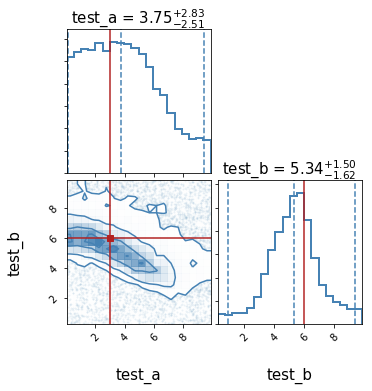

In [9]:
from imagine.pipelines.dynesty_pipeline import DynestyPipeline

pipe = DynestyPipeline(simer, factory_list, likelihood, prior, ensemble_size)
pipe.random_seed = 0
pipe.sampling_controllers = {'nlive': 4000} # mind the difference here

results = pipe()
samples = results['samples']
for i in range(len(pipe.active_parameters)):
    low, high = pipe.active_ranges[pipe.active_parameters[i]]
    for j in range(samples.shape[0]):
        samples[j, i] = unity_mapper(samples[j, i], low, high)
# corner plot
figure = corner.corner(samples[:, :len(pipe.active_parameters)],
                       range=[0.99]*len(pipe.active_parameters),
                       quantiles=[0.02, 0.5, 0.98],
                       labels=pipe.active_parameters,
                       show_titles=True,
                       title_kwargs={"fontsize": 15},
                       color='steelblue',
                       truths=[a0,b0],
                       truth_color='firebrick',
                       plot_contours=True,
                       hist_kwargs={'linewidth': 2},
                       label_kwargs={'fontsize': 15})

## convergence check

iter: 16665+4000 | bound: 6 | nc: 1 | ncall: 178476 | eff(%): 11.579 | loglstar:   -inf < -86.758 <    inf | logz: -93.895 +/-  0.179 | dlogz:  0.005 >  4.009              

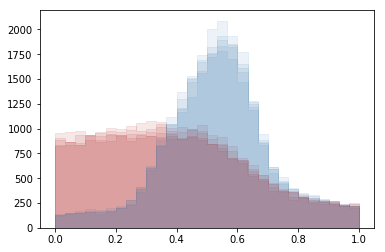

In [6]:
from scipy.stats import norm
repeat = 5

for i in range(repeat):
    tmp = pipe()
    asamp = tmp['samples'][:,0]
    bsamp = tmp['samples'][:,1]
    matplotlib.pyplot.hist(asamp,30,histtype='step',stacked=True,fill=True,color='firebrick',alpha=0.1)
    matplotlib.pyplot.hist(bsamp,30,histtype='step',stacked=True,fill=True,label='b',color='steelblue',alpha=0.1)